In [1]:
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import integrate
import numpy as np

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6

Mbar=10**10 #Msun, half of what Wang is using, same as Pearson


def rho1(R,z):
    return (2.*np.pi*x0*y0)*R*np.exp(-0.5*(np.sqrt(R**4 + (z/z0)**4)))

rho1norm= integrate.nquad(rho1,[[0,np.inf],[-np.inf,np.inf]])[0]

def rho2(R):
    return (z0**1.85 *4.*np.pi/q**2)*R**(0.15)*np.exp(-R/z0)

rho2norm= integrate.quad(rho2,0,np.inf)[0]


rho0=Mbar/(rho1norm + rho2norm)

print (rho0)

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar_xyz(z,y,x):
    return rho0*(np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x)))

1084351671.92


/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in power



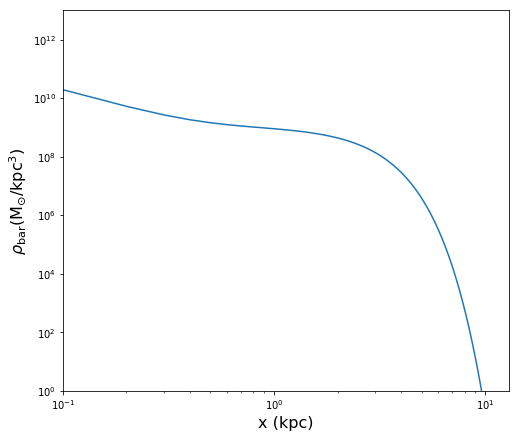

In [3]:
xx=np.linspace(0.,10.,100)
yy=np.zeros(100)
zz=np.zeros(100)

plt.figure(figsize=(8,7))
plt.loglog(xx,rho_bar_xyz(zz,yy,xx))
plt.ylim(1.,10**13.)
plt.xlim(0.1,13.)
plt.ylabel(r'$\rho_{\rm{bar}} (\rm{M}_{\odot}/\rm{kpc}^{3})$ ',fontsize=16)
plt.xlabel(r'x (kpc)',fontsize=16)
plt.show()

In [4]:
#define function for the bar density, using form from Dwek (1995) as of now
# transformed from cartesian to cylindrical for galpy

def r1c(R,z,p):
    return ((R**4.)*(np.cos(p)**2./x0**2 + np.sin(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return rho0*(np.exp(-r1c(R,z,p)**2./2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z)))



In [5]:
ro=8.
vo=220.

Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/(10**9.*bovy_conversion.dens_in_msolpc3(220.,8.)),
                                        3,7,a=1./ro,radial_order=30,costheta_order=30,phi_order=30)

 #following Pearson et al N=2 and L=6
# a is same as r_s in Wang et al 2012

#print Acos

In [6]:
print (Acos[0,0,0]/Acos[1,0,0])
print (Acos[0,0,0]/Acos[2,0,0])
print (Acos[2,0,0]/Acos[1,0,0])


scfbaraxi=potential.SCFPotential(amp=1,Acos=numpy.atleast_3d(Acos[:,:,0]),a=0.125)
scfbaraxi.mass(3.,2.,use_physical=False)*bovy_conversion.mass_in_1010msol(220.,8.)



-17.4643110347
-45.1352809012
0.386932587678


1.0388355326613032

In [7]:
#mass of the disk
MWPotential2014[1].mass(10.,5.,use_physical=False)*bovy_conversion.mass_in_1010msol(220.,8.)

6.563620225134988

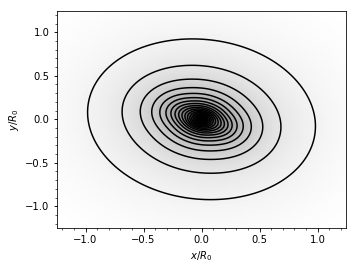

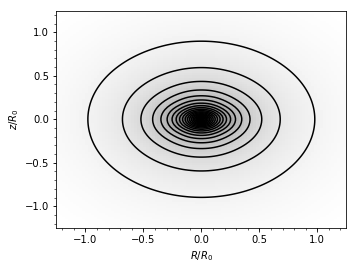

In [8]:
scfbar=potential.SCFPotential(amp=1.,Acos=Acos,Asin=Asin,a=0.125)




pat_speed = 35. #(km/s/kpc)
omegaP=pat_speed*(ro/vo)



scfbarrot=potential.SolidBodyRotationWrapperPotential(pot=scfbar, omega=omegaP,ro=ro,vo=vo,pa=np.radians(180.-27.))
#pa = 27 deg taken from Pearson et al,.

from galpy.potential import MiyamotoNagaiPotential, turn_physical_off

MWPotential2014SCFbar= [MiyamotoNagaiPotential(amp=(6.8+0.5-1.)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],scfbarrot]
turn_physical_off(MWPotential2014SCFbar)

#MWPotential2014SCFbar= [MWPotential2014[1],MWPotential2014[2],scfbarrot]


potential.plotPotentials(scfbarrot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)

potential.plotPotentials(scfbarrot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=False,phi=0.)

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: invalid value encountered in divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:258: RuntimeWarning: invalid value encountered in multiply
  func = func_tilde[:,:,None]*(Acos[:,:,:]*mcos + Asin[:,:,:]*msin)*PP[None,:,:]



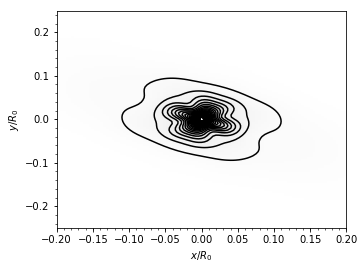

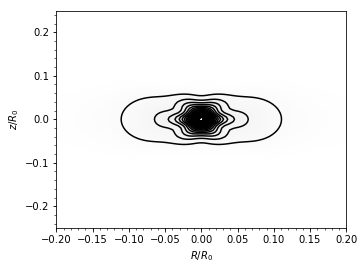

In [9]:
from galpy.potential import plotDensities
plotDensities(scfbarrot,rmin=-0.2,rmax=0.2,zmax=0.25,zmin=-0.25,phi=0.,nrs=101,nzs=101,ncontours=50,xy=True)
plotDensities(scfbarrot,rmin=-0.2,rmax=0.2,zmax=0.25,zmin=-0.25,phi=0.,nrs=101,nzs=101,ncontours=50)

223.459401476


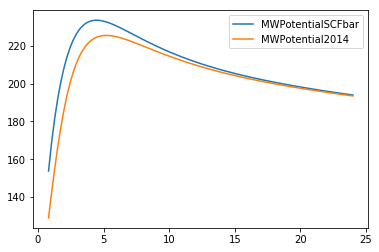

In [10]:
print (potential.vcirc(MWPotential2014SCFbar,1.,phi=0)*vo)

rr=np.linspace(0.1,3.,100)
vcc=[potential.vcirc(MWPotential2014SCFbar,r,phi=0)*vo for r in rr]
vccfid=[potential.vcirc(MWPotential2014,r)*vo for r in rr]

plt.figure()
plt.plot(rr*8.,vcc,label='MWPotentialSCFbar')
plt.plot(rr*8.,vccfid,label='MWPotential2014')
plt.legend(loc='upper right')
plt.show()

In [11]:
from galpy.potential import evaluatezforces

print (-evaluatezforces(MWPotential2014SCFbar, 1.,1.1/8.,phi=0.)*bovy_conversion.force_in_2piGmsolpc2(220.,8.))

print (-evaluatezforces(MWPotential2014, 1.,1.1/8.,phi=0.)*bovy_conversion.force_in_2piGmsolpc2(220.,8.))

70.1769844365
71.6760564305


In [ ]:
#plot orbits

ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,potential.MWPotential2014)
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True)
    o.integrate(ts,MWPotential2014SCFbar)
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,potential.MWPotential2014)
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True)
    o.integrate(ts,MWPotential2014SCFbar)
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()


In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
tight_layout()

In [12]:
#setup Pal 5 smooth stream, only the trailing arm at the moment
sdf_trailing= pal5_util.setup_pal5model()

#Sample N points from the smooth model today 
N=1000
R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)

#add color label based on time of stripping

#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

l_unp=numpy.empty(N)
b_unp=numpy.empty(N)
dt_s=numpy.empty(N)

for i in range(N):
    dt_s[i]=numpy.digitize(dt[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    l_unp[i]=galcencyl_to_lbd(R[i],phi[i],z[i])[0]
    b_unp[i]=galcencyl_to_lbd(R[i],phi[i],z[i])[1]
    
radec1=bovy_coords.lb_to_radec(l_unp,b_unp,degree=True)  

[ 0.  1.  2.  3.  4.  5.]


In [13]:
cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

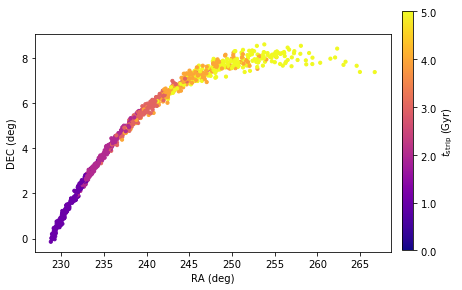

In [14]:
#plot unperturbed stream 


plt.figure()
plt.scatter(radec1[:,0],radec1[:,1],s=10,color=color_from_colormap(dt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='r')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
plt.show()


234


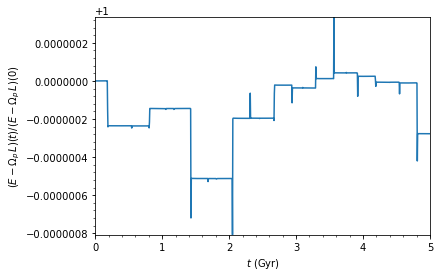

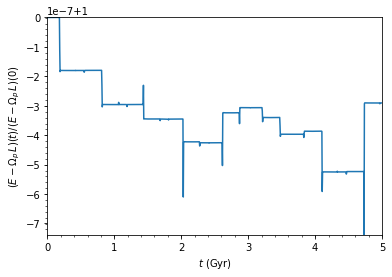

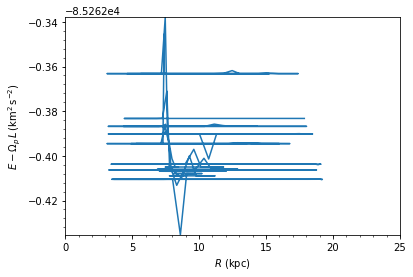

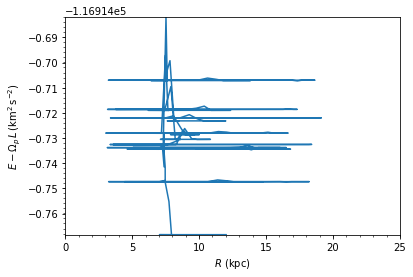

In [19]:
#plot Jacobi integral to check whether it is conserved
from random import randint
ind=randint(0,len(R)-1)
print (ind)

#SCF no bar
MWPotential2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-1.)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],scfbaraxi]

ts= numpy.linspace(0,5.0,1001)/bovy_conversion.time_in_Gyr(220.,8.)
o1= Orbit([R[ind],vR[ind],vT[ind],z[ind],vz[ind],phi[ind]],ro=ro,vo=vo)
o1.integrate(ts,MWPotential2014SCFnobar)
o1.plotJacobi(normed=True)

obar= Orbit([R[ind],vR[ind],vT[ind],z[ind],vz[ind],phi[ind]],ro=ro,vo=vo)
obar.integrate(ts,MWPotential2014SCFbar)
obar.plotJacobi(normed=True)

#plot Jacobi integral w.r.t the radius 

o1.plot(d1='R',d2='Jacobi',xrange=[0.,25])

obar.plot(d1='R',d2='Jacobi',xrange=[0.,25])
#axvline(dp._rb*ro,c='r') # this plots the bar radius


In [20]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like
orbits= []
for ii in range(N):
    o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip() # flip flips the velocities for backwards integration
    ts= numpy.linspace(0.,dt[ii],1001)
    o.integrate(ts,MWPotential2014)
    orbits.append(o(ts[-1]).flip()) # get the orbit at the final time step, flip the velocities for forward integration below

In [21]:
#integrate all points *forward* in time in the barred potential 
# MWPotential2014SCFbar
orbits1=orbits

finalR= numpy.empty(N)
finalphi= numpy.empty(N)
finalz= numpy.empty(N)
for ii in range(N):
    ts= numpy.linspace(0.,dt[ii],1001)
    orbits[ii].integrate(ts,MWPotential2014SCFbar)
    finalR[ii]= orbits[ii].R(ts[-1])
    finalphi[ii]= orbits[ii].phi(ts[-1])
    finalz[ii]= orbits[ii].z(ts[-1])

#SCF no bar    
finalR_nobar= numpy.empty(N)
finalphi_nobar= numpy.empty(N)
finalz_nobar= numpy.empty(N)
for ii in range(N):
    ts= numpy.linspace(0.,dt[ii],1001)
    orbits1[ii].integrate(ts,MWPotential2014SCFnobar)
    finalR_nobar[ii]= orbits1[ii].R(ts[-1])
    finalphi_nobar[ii]= orbits1[ii].phi(ts[-1])
    finalz_nobar[ii]= orbits1[ii].z(ts[-1])
    

In [22]:
l_p=numpy.empty(N)
b_p=numpy.empty(N)

for i in range(N):
    l_p[i]=galcencyl_to_lbd(finalR[i],finalphi[i],finalz[i])[0]
    b_p[i]=galcencyl_to_lbd(finalR[i],finalphi[i],finalz[i])[1]
    
radec=bovy_coords.lb_to_radec(l_p,b_p,degree=True)   

l_p_nobar=numpy.empty(N)
b_p_nobar=numpy.empty(N)

for i in range(N):
    l_p_nobar[i]=galcencyl_to_lbd(finalR_nobar[i],finalphi_nobar[i],finalz_nobar[i])[0]
    b_p_nobar[i]=galcencyl_to_lbd(finalR_nobar[i],finalphi_nobar[i],finalz_nobar[i])[1]
    
radec_nobar=bovy_coords.lb_to_radec(l_p_nobar,b_p_nobar,degree=True)   

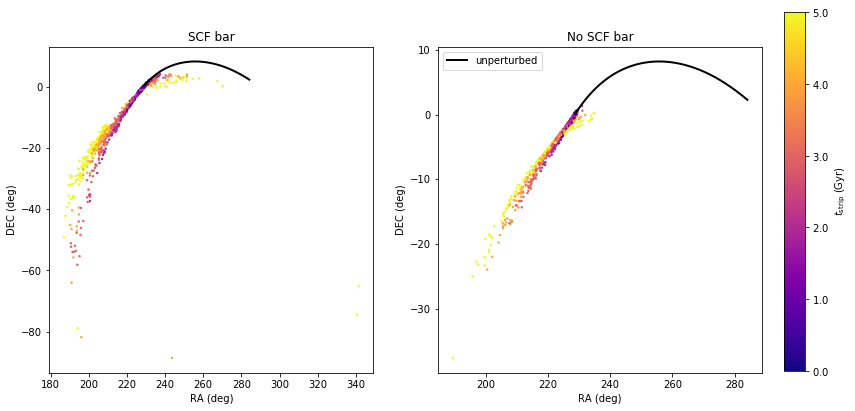

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1,2, 1)
plt.title('SCF bar')
plt.scatter(radec[:,0],radec[:,1],s=2,color=color_from_colormap(dt_s,cmap,0.,5.))
plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')



plt.subplot(1, 2, 2)
plt.title('No SCF bar')
plt.scatter(radec_nobar[:,0],radec_nobar[:,1],s=2,color=color_from_colormap(dt_s,cmap,0.,5.))
plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend(loc='upper left')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')

#plt.tight_layout()
plt.show()


    

In [ ]:
#in spherical coordinates

def r1s(R,t,p):
    return R* ( np.sin(t)**4. + np.cos(t)**4.)**(0.25)

def r2s(R,t,p):
    return R*( (q*np.sin(t)/z0)**2. * ((x0*np.cos(p))**2. + (y0*np.sin(p))**2.)  + np.cos(t)**2. )**0.5


def rho_bar_sp(R,t,p):
    return np.exp(-r1s(R,t,p)**2./2.) + r2s(R,t,p)**(-1.85)*np.exp(-r2s(R,t,p))


In [ ]:
#Learn how to use triple quad

from scipy import integrate
import numpy as np

a=2.
b=3.
c=4.

#Return the triple integral of func(z, y, x) from x = a..b, y = gfun(x)..hfun(x), and z = qfun(x,y)..rfun(x,y).

def rfun(x,y):
    return c*np.sqrt(1 - (x/a)**2 - (y/b)**2)

def qfun(x,y):
    return 0.

def gfun(x):
    return 0.

def hfun(x):
    return b*np.sqrt(1-(x/a)**2.)

def ff(z,y,x):
    return 1.

print 8.*integrate.tplquad(ff,0.,2.,gfun,hfun,qfun,rfun)[0]

print 4.*np.pi*a*b*c/3.

In [ ]:
print rho0

In [ ]:
import numpy as np
from scipy import integrate

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6
r0=np.sqrt(x0**2 + y0**2 + z0**2)

Mbar=2*10**10 #Msun

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar(z,y,x):
    return np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x))

xx=np.linspace(-5.,5.,10000)
yy=np.linspace(-5.,5.,10000)
zz=np.linspace(-5.,5.,10000)




In [ ]:
from mayavi import mlab 
figure = mlab.figure('Bar density')
pts = mlab.points3d(xx, yy, zz, rho_bar, scale_mode='none', scale_factor=0.7)
mlab.axes()
mlab.show()

In [ ]:
from scipy import integrate
import numpy as np

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6
r0=np.sqrt(x0**2 + y0**2 + z0**2)

Mbar=2*10**10 #Msun

def r1(z,y,x):
    return (((x/x0)**2. + (y/y0)**2.)**2. + (z/z0)**4)**(0.25)

def r2(z,y,x):
    return (1/z0)*(q*(x**2 + y**2) + z**2)**(0.5)

def rho_bar(z,y,x):
    return np.exp(-0.5*r1(z,y,x)**2.) + (r2(z,y,x)**(-1.85))*np.exp(-r2(z,y,x))



def rfun(x,y):
    return z0*np.sqrt(1 - (x/x0)**2 - (y/y0)**2)

def qfun(x,y):
    return 0.

def hfun(x):
    return y0*np.sqrt(1-(x/x0)**2.)

def gfun(x):
    return 0.

#the density form has the symmetry under x --> -x , y --> -y, z--> -z 

norm= 8.*integrate.tplquad(rho_bar,0.,x0,gfun,hfun,qfun,rfun)[0]

print norm

rho0=Mbar/norm

In [ ]:
def ff2(R):
    

print integrate.quad(ff2,0,np.inf)[0]

In [ ]:
print 2./4*2